## Assignment B

1.Design a 3-layer feedforward neural network consisting of a hidden-layer of 30 neurons. Use mini-batch gradient descent (with batch size of 32 and learning rate 𝛼 = 10−4 to train the network. Use up to about 1000 epochs for this problem.
* Plot the training error against number of epochs for the 3-layer network.
* Plot the final test errors of prediction by the network.

In [ ]:
import time
import numpy as np
import theano
import theano.tensor as T

import matplotlib.pyplot as plt

# scale and normalize input data
def scale(X, X_min, X_max):
    return (X - X_min) / (X_max - X_min)

def shuffle_data(samples, labels):
    idx = np.arange(samples.shape[0])
    np.random.shuffle(idx)
    # print  (samples.shape, labels.shape)
    samples, labels = samples[idx], labels[idx]
    return samples, labels

def init_bias(n=1):
    return (theano.shared(np.zeros(n) if n != 1 else 0., theano.config.floatX))

def init_weights(n_in=1, n_out=1, logistic=True):
    W_values = np.random.uniform(low=-np.sqrt(6. / (n_in + n_out)),
                                 high=np.sqrt(6. / (n_in + n_out)),
                                 size=(n_in, n_out))
    if logistic == True:
        W_values *= 4
    return (theano.shared(W_values, theano.config.floatX))

def set_bias(b, n=1):
    b.set_value(np.zeros(n) if n != 1 else 0.)

def set_weights(w, n_in=1, n_out=1, logistic=True):
    W_values = np.random.uniform(low=-np.sqrt(6. / (n_in + n_out)),
                                 high=np.sqrt(6. / (n_in + n_out)),
                                 size=(n_in, n_out))
    if logistic == True:
        W_values *= 4
    w.set_value(W_values)

def preprocess_data(dataset):
    # read and divide data into test and train sets
    cal_housing = np.loadtxt(dataset, delimiter=',')
    X_data, Y_data = cal_housing[:, :8], cal_housing[:, -1]
    Y_data = (np.asmatrix(Y_data)).transpose()

    X_data, Y_data = shuffle_data(X_data, Y_data)

    # separate train and test data
    m = 3 * X_data.shape[0] // 10
    testX, testY = X_data[:m], Y_data[:m]
    trainX, trainY = X_data[m:], Y_data[m:]

    # scale and normalize data
    trainX_max, trainX_min = np.max(trainX, axis=0), np.min(trainX, axis=0)
    trainY_max, trainY_min = np.max(trainY, axis=0), np.min(trainY, axis=0)
    # testX_max, testX_min = np.max(testX, axis=0), np.min(testX, axis=0)

    trainX, trainY = scale(trainX, trainX_min, trainX_max), scale(trainY, trainY_min, trainY_max)
    testX, testY = scale(testX, trainX_min, trainX_max), scale(testY, trainY_min, trainY_max)

    return trainX, testX, trainY, testY

def initialize_weights_bias_3_layer(no_features, no_hidden1, no_output):
    w_o = init_weights(no_hidden1, no_output, False)
    w_h1 = init_weights(no_features, no_hidden1)
    b_o = init_bias(no_output)
    b_h1 = init_bias(no_hidden1)
    return w_o, w_h1, b_o, b_h1

def reset_weights_3_layer(no_features, no_hidden1, no_output):
    set_weights(w_o, no_hidden1, no_output, False)
    set_weights(w_h1, no_features, no_hidden1)
    set_bias(b_o, no_output)
    set_bias(b_h1, no_hidden1)

def create_3_layer_nn():
    x = T.matrix('x')  # data sample
    d = T.matrix('d')  # desired output
    no_samples = T.scalar('no_samples')

    # Define mathematical expression:
    h1_out = T.nnet.sigmoid(T.dot(x, w_h1) + b_h1)
    y = T.dot(h1_out, w_o) + b_o

    cost = T.abs_(T.mean(T.sqr(d - y)))
    accuracy = T.mean(d - y)

    # define gradients
    dw_o, db_o, dw_h, db_h = T.grad(cost, [w_o, b_o, w_h1, b_h1])

    train = theano.function(
        inputs=[x, d],
        outputs=cost,
        updates=[[w_o, w_o - alpha * dw_o],
                 [b_o, b_o - alpha * db_o],
                 [w_h1, w_h1 - alpha * dw_h],
                 [b_h1, b_h1 - alpha * db_h]],
        allow_input_downcast=True
    )

    test = theano.function(
        inputs=[x, d],
        outputs=[y, cost, accuracy],
        allow_input_downcast=True
    )

    return train, test

def run_nn_3_layer(train, test, batch_size, trainX, trainY, testX, testY, epochs, no_features, no_hidden1, no_output):
    min_error = 1e+15
    best_iter = 0
    best_w_o = np.zeros(no_hidden1)
    best_w_h1 = np.zeros([no_features, no_hidden1])
    best_b_o = 0
    best_b_h1 = np.zeros(no_hidden1)

    train_cost = np.zeros(epochs)
    test_cost = np.zeros(epochs)
    test_accuracy = np.zeros(epochs)

    reset_weights_3_layer(no_features, no_hidden1, no_output)

    # train with best value
    for iter in range(epochs):
        if iter % 500 == 0:
            print("Iter:", iter)

        trainX, trainY = shuffle_data(trainX, trainY)
        train_cost[iter] = train(trainX, trainY)
        pred, test_cost[iter], test_accuracy[iter] = test(testX, testY)

        if test_cost[iter] < min_error:
            best_iter = iter
            min_error = test_cost[iter]
            best_w_o = w_o.get_value()
            best_w_h1 = w_h1.get_value()
            best_b_o = b_o.get_value()
            best_b_h1 = b_h1.get_value()

    # set weights and biases to values at which performance was best
    w_o.set_value(best_w_o)
    b_o.set_value(best_b_o)
    w_h1.set_value(best_w_h1)
    b_h1.set_value(best_b_h1)

    best_pred, best_cost, best_accuracy = test(testX, testY)

    print('Minimum error: %f, Best accuracy %.1f, Number of Iterations: %d' % (best_cost, best_accuracy, best_iter))

    # Plots
    plt.figure()
    plt.plot(range(epochs), train_cost, label='train error')
    plt.plot(range(epochs), test_cost, label='test error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Training and Test Errors at Alpha = %.5f' % alpha.get_value())
    plt.legend()
    plt.savefig('p_1b_mse.png')
    plt.show()
    return train_cost, test_cost

# Scale, normalize, and separate data to train/test
np.random.seed(10)
epochs = 1000
batch_size = 32
no_hidden1 = 60  # num of neurons in hidden layer 1
learning_rate = 0.0001

trainX, testX, trainY, testY = preprocess_data('cal_housing.data')

no_features = trainX.shape[1]
no_output = trainY.shape[1]

alpha = theano.shared(learning_rate, theano.config.floatX)
w_o, w_h1, b_o, b_h1 = initialize_weights_bias_3_layer(no_features, no_hidden1, no_output)
train, test = create_3_layer_nn()
run_3layer_train, run_3layer_test = run_nn_3_layer(train, test, batch_size, trainX, trainY, testX, testY, epochs, no_features, no_hidden1, no_output)

2.Find the optimal learning rate for the 3-layer network designed. Set this as the learning rate in first hidden layer for the rest of the experiments.
* Plot the training errors and validation errors against number of epochs for the 3-layer network for different learning rates. Limit the search space to: {10−3, 0.5 × 10−3 , 10−4 ,0.5 × 10−4, 10−5}
* Plot the test errors against number of epochs for the optimum learning rate.
* State the rationale behind selecting the optimal learning rate.

Exp, Alpha: 0 , 0.001
Exp, Alpha: 0 , 0.0005
Exp, Alpha: 0 , 0.0001
Exp, Alpha: 0 , 5e-05
Exp, Alpha: 0 , 1e-05
Test cost: [ 0.05908757  0.05737481  0.06633487  0.08440749  0.29502998]
Best values for each experiments [ 0.0005]
Best learning rate: 0.0005
Iter: 0
Iter: 500
Minimum error: 0.056599, Best accuracy 0.0, Number of Iterations: 999


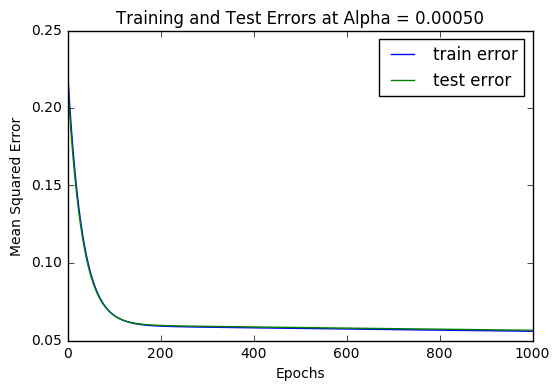

In [3]:
no_folds = 5
no_exps = 1
alpha_values = [10 ** -3, 0.5 * 10 ** -3, 10 ** -4, 0.5 * 10 ** -4, 10 ** -5]

def kfold_alpha(no_exps, values, no_fold, epochs, trainX, trainY, train, test, no_features, no_hidden1, no_output):
    t = time.time()
    fold_division = trainX.shape[0] // no_fold

    # repeat 5-fold validation for each value
    opt_val = []
    for exp in range(no_exps):
        trainX, trainY = shuffle_data(trainX, trainY)
        test_cost = []
        for val in values:
            print("Exp, Alpha:", exp, ",", val)
            reset_weights_3_layer(no_features, no_hidden1, no_output)
            alpha.set_value(val)
            fold_cost = []
            for fold in range(no_folds):
                start, end = fold * fold_division, (fold + 1) * fold_division
                testFoldX, testFoldY = trainX[start:end], trainY[start:end]
                trainFoldX, trainFoldY = np.append(trainX[:start], trainX[end:], axis=0), np.append(trainY[:start],
                                                                                                    trainY[end:], axis=0)
                # reset weights
                reset_weights_3_layer(no_features, no_hidden1, no_output)
                min_cost = 1e+15
                for iter in range(epochs):
                    train(trainFoldX, trainFoldY)
                    err = test(testFoldX, testFoldY)[1]
                    if err < min_cost:
                        min_cost = err
                fold_cost = np.append(fold_cost, min_cost)
            # test cost for each value
            test_cost = np.append(test_cost, np.mean(fold_cost))
        print("Test cost:", test_cost)
        # array of value with least test cost for each experiment
        opt_val = np.append(opt_val, values[np.argmin(test_cost)])

    # Select best value of parameter
    print("Best values for each experiments", opt_val)
    counts = []
    for val in values:
        counts = np.append(counts, np.sum(opt_val == val))
    # print(counts)
    opt_val = values[np.argmax(counts)]
    return opt_val

w_o, w_h1, b_o, b_h1 = initialize_weights_bias_3_layer(no_features, no_hidden1, no_output)
train, test = create_3_layer_nn()
learning_rate = kfold_alpha(no_exps, alpha_values, no_folds, epochs, trainX, trainY, train, test, no_features, no_hidden1, no_output)
print("Best learning rate:", learning_rate)
alpha.set_value(learning_rate)

run_alpha_train, run_alpha_test = run_nn_3_layer(train, test, batch_size, trainX, trainY, testX, testY, epochs, no_features, no_hidden1, no_output)

3.Find the optimal number of hidden neurons for the 3-layer network designed.
* Plot the training errors against number of epochs for the 3-layer network for different hidden-layer neurons. Limit search space to:{20,30,40,50,60}.
* Plot the test errors against number of epochs for the optimum number of hidden layer neurons.
* State the rationale behind selecting the optimal number of hidden neurons

Exp, Iteration: 0 , 20
Exp, Iteration: 0 , 30
Exp, Iteration: 0 , 40
Exp, Iteration: 0 , 50
Exp, Iteration: 0 , 60
Test cost: [ 0.06899687  0.06907726  0.0728007   0.06050984  0.05480803]
Best values for each experiments [ 60.]
Best hidden neuron number:  60
Iter: 0
Iter: 500
Minimum error: 0.071463, Best accuracy 0.0, Number of Iterations: 999


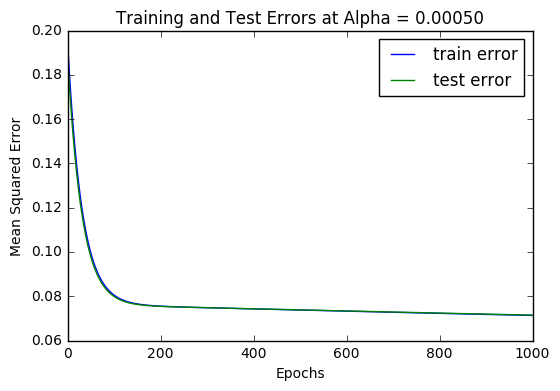

In [5]:
hidden_values = [20, 30, 40, 50, 60]

def kfold_hidden(no_exps, values, no_fold, epochs, trainX, trainY, train, test, no_features, no_hidden1, no_output):
    t = time.time()
    fold_division = trainX.shape[0] // no_fold

    # repeat 5-fold validation for each value
    opt_val = []
    for exp in range(no_exps):
        trainX, trainY = shuffle_data(trainX, trainY)
        test_cost = []
        for val in values:
            print("Exp, Iteration:", exp, ",", val)
            reset_weights_3_layer(no_features, no_hidden1, no_output)
            fold_cost = []
            for fold in range(no_folds):
                start, end = fold * fold_division, (fold + 1) * fold_division
                testFoldX, testFoldY = trainX[start:end], trainY[start:end]
                trainFoldX, trainFoldY = np.append(trainX[:start], trainX[end:], axis=0), np.append(trainY[:start],
                                                                                                    trainY[end:], axis=0)
                # reset weights
                reset_weights_3_layer(no_features, no_hidden1, no_output)
                min_cost = 1e+15
                for iter in range(epochs):
                    train(trainFoldX, trainFoldY)
                    err = test(testFoldX, testFoldY)[1]
                    if err < min_cost:
                        min_cost = err
                fold_cost = np.append(fold_cost, min_cost)
            # test cost for each value
            test_cost = np.append(test_cost, np.mean(fold_cost))
        print("Test cost:", test_cost)
        # array of value with least test cost for each experiment
        opt_val = np.append(opt_val, values[np.argmin(test_cost)])

    print("Best values for each experiments", opt_val)
    # Select best value of parameter
    counts = []
    for val in values:
        counts = np.append(counts, np.sum(opt_val == val))
    # print(counts)
    opt_val = values[np.argmax(counts)]
    return opt_val

w_o, w_h1, b_o, b_h1 = initialize_weights_bias_3_layer(no_features, no_hidden1, no_output)
train, test = create_3_layer_nn()
no_hidden1 = kfold_hidden(no_exps, hidden_values, no_folds, epochs, trainX, trainY, train, test, no_features, no_hidden1, no_output)
print("Best hidden neuron number: ", no_hidden1)

run_hidden_train, run_hidden_test = run_nn_3_layer(train, test, batch_size, trainX, trainY, testX, testY, epochs, no_features, no_hidden1, no_output)

4.Design a four-layer neural network and a five-layer neural network, with the first hidden layer having number of neurons found in step (3) and other hidden layers having 20 neurons each. Use a learning rate of 𝛼 = 10−4. Plot the test errors of the 4-layer network and 5-layer network, and compare them with that of the 3-layer network.

Iter: 0
Iter: 500
Minimum error: 0.088589, Best accuracy 0.2, Number of Iterations: 999


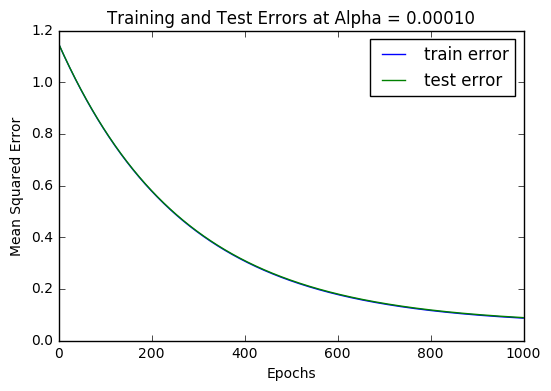

In [6]:
def initialize_weights_bias_4_layer(no_features, no_hidden1, no_hidden2, no_output):
    w_o = init_weights(no_hidden2, no_output, False)
    w_h1 = init_weights(no_features, no_hidden1)
    w_h2 = init_weights(no_hidden1, no_hidden2)
    b_o = init_bias(no_output)
    b_h1 = init_bias(no_hidden1)
    b_h2 = init_bias(no_hidden2)

    return w_o, w_h1, w_h2, b_o, b_h1, b_h2

def reset_weights_4_layer(no_features, no_hidden1, no_hidden2, no_output):
    set_weights(w_o, no_hidden2, no_output, False)
    set_weights(w_h1, no_features, no_hidden1)
    set_weights(w_h2, no_hidden1, no_hidden2)
    set_bias(b_o, no_output)
    set_bias(b_h1, no_hidden1)
    set_bias(b_h2, no_hidden2)

def create_4_layer_nn():
    x = T.matrix('x')  # data sample
    d = T.matrix('d')  # desired output
    no_samples = T.scalar('no_samples')

    # Define mathematical expression:
    h1_out = T.nnet.sigmoid(T.dot(x, w_h1) + b_h1)
    h2_out = T.nnet.sigmoid(T.dot(h1_out, w_h2) + b_h2)
    y = T.dot(h2_out, w_o) + b_o

    cost = T.abs_(T.mean(T.sqr(d - y)))
    accuracy = T.mean(d - y)

    # define gradients
    dw_o, db_o, dw_h, db_h, dw_h2, db_h2 = T.grad(cost, [w_o, b_o, w_h1, b_h1, w_h2, b_h2])

    train = theano.function(
        inputs=[x, d],
        outputs=cost,
        updates=[[w_o, w_o - alpha * dw_o],
                 [b_o, b_o - alpha * db_o],
                 [w_h1, w_h1 - alpha * dw_h],
                 [b_h1, b_h1 - alpha * db_h],
                 [w_h2, w_h2 - alpha * dw_h2],
                 [b_h2, b_h2 - alpha * db_h2]],
        allow_input_downcast=True
    )

    test = theano.function(
        inputs=[x, d],
        outputs=[y, cost, accuracy],
        allow_input_downcast=True
    )

    return train, test

def run_nn_4_layer(train, test, batch_size, trainX, trainY, testX, testY, epochs, no_features, no_hidden1, no_hidden2, no_output):
    min_error = 1e+15
    best_iter = 0
    best_w_o = np.zeros(no_hidden2)
    best_w_h1 = np.zeros([no_features, no_hidden1])
    best_w_h2 = np.zeros([no_hidden1, no_hidden2])
    best_b_o = 0
    best_b_h1 = np.zeros(no_hidden1)
    best_b_h2 = np.zeros(no_hidden2)

    train_cost = np.zeros(epochs)
    test_cost = np.zeros(epochs)
    test_accuracy = np.zeros(epochs)

    reset_weights_4_layer(no_features, no_hidden1, no_hidden2, no_output)

    # train with best value
    for iter in range(epochs):
        if iter % 500 == 0:
            print("Iter:", iter)

        trainX, trainY = shuffle_data(trainX, trainY)
        train_cost[iter] = train(trainX, trainY)
        pred, test_cost[iter], test_accuracy[iter] = test(testX, testY)

        if test_cost[iter] < min_error:
            best_iter = iter
            min_error = test_cost[iter]
            best_w_o = w_o.get_value()
            best_w_h1 = w_h1.get_value()
            best_w_h2 = w_h2.get_value()
            best_b_o = b_o.get_value()
            best_b_h1 = b_h1.get_value()
            best_b_h2 = b_h2.get_value()

    # set weights and biases to values at which performance was best
    w_o.set_value(best_w_o)
    b_o.set_value(best_b_o)
    w_h1.set_value(best_w_h1)
    b_h1.set_value(best_b_h1)
    w_h2.set_value(best_w_h2)
    b_h2.set_value(best_b_h2)

    best_pred, best_cost, best_accuracy = test(testX, testY)

    print('Minimum error: %f, Best accuracy %.1f, Number of Iterations: %d' % (best_cost, best_accuracy, best_iter))

    # Plots
    plt.figure()
    plt.plot(range(epochs), train_cost, label='train error')
    plt.plot(range(epochs), test_cost, label='test error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Training and Test Errors at Alpha = %.5f' % alpha.get_value())
    plt.legend()
    plt.savefig('p_1b_mse_4_layer.png')
    plt.show()
    return train_cost, test_cost

epochs = 1000
no_hidden2 = 20
learning_rate = 0.0001

alpha = theano.shared(learning_rate, theano.config.floatX)

w_o, w_h1, w_h2, b_o, b_h1, b_h2 = initialize_weights_bias_4_layer(no_features, no_hidden1, no_hidden2, no_output)
train, test = create_4_layer_nn()
run_4layer_train, run_4layer_test = run_nn_4_layer(train, test, batch_size, trainX, trainY, testX, testY, epochs, no_features, no_hidden1, no_hidden2, no_output)

Iter: 0
Iter: 500
Minimum error: 0.069218, Best accuracy 0.1, Number of Iterations: 999


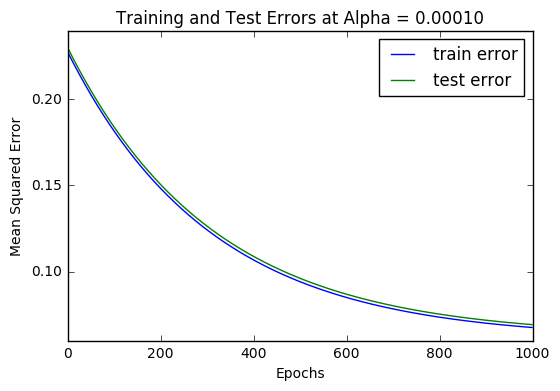

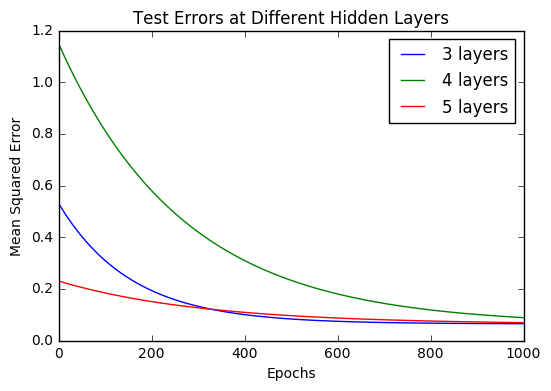

In [7]:
def initialize_weights_bias_5_layer(no_features, no_hidden1, no_hidden2, no_hidden3, no_output):
    w_o = init_weights(no_hidden3, no_output, False)
    w_h1 = init_weights(no_features, no_hidden1)
    w_h2 = init_weights(no_hidden1, no_hidden2)
    w_h3 = init_weights(no_hidden2, no_hidden3)
    b_o = init_bias(no_output)
    b_h1 = init_bias(no_hidden1)
    b_h2 = init_bias(no_hidden2)
    b_h3 = init_bias(no_hidden3)
    return w_o, w_h1, w_h2, w_h3, b_o, b_h1, b_h2, b_h3

def reset_weights_5_layer(no_features, no_hidden1, no_hidden2, no_hidden3, no_output):
    set_weights(w_o, no_hidden3, no_output, False)
    set_weights(w_h1, no_features, no_hidden1)
    set_weights(w_h2, no_hidden1, no_hidden2)
    set_weights(w_h3, no_hidden2, no_hidden3)
    set_bias(b_o, no_output)
    set_bias(b_h1, no_hidden1)
    set_bias(b_h2, no_hidden2)
    set_bias(b_h3, no_hidden3)

def create_5_layer_nn():
    x = T.matrix('x')  # data sample
    d = T.matrix('d')  # desired output
    no_samples = T.scalar('no_samples')

    # Define mathematical expression:
    h1_out = T.nnet.sigmoid(T.dot(x, w_h1) + b_h1)
    h2_out = T.nnet.sigmoid(T.dot(h1_out, w_h2) + b_h2)
    h3_out = T.nnet.sigmoid(T.dot(h2_out, w_h3) + b_h3)
    y = T.dot(h3_out, w_o) + b_o

    cost = T.abs_(T.mean(T.sqr(d - y)))
    accuracy = T.mean(d - y)

    # define gradients
    dw_o, db_o, dw_h, db_h, dw_h2, db_h2, dw_h3, db_h3 = T.grad(cost, [w_o, b_o, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3])

    train = theano.function(
        inputs=[x, d],
        outputs=cost,
        updates=[[w_o, w_o - alpha * dw_o],
                 [b_o, b_o - alpha * db_o],
                 [w_h1, w_h1 - alpha * dw_h],
                 [b_h1, b_h1 - alpha * db_h],
                 [w_h2, w_h2 - alpha * dw_h2],
                 [b_h2, b_h2 - alpha * db_h2],
                 [w_h3, w_h3 - alpha * dw_h3],
                 [b_h3, b_h3 - alpha * db_h3]],
        allow_input_downcast=True
    )

    test = theano.function(
        inputs=[x, d],
        outputs=[y, cost, accuracy],
        allow_input_downcast=True
    )

    return train, test

def run_nn_5_layer(train, test, batch_size, trainX, trainY, testX, testY, epochs, no_features, no_hidden1, no_hidden2, no_hidden3, no_output):
    min_error = 1e+15
    best_iter = 0
    best_w_o = np.zeros(no_hidden3)
    best_w_h1 = np.zeros([no_features, no_hidden1])
    best_w_h2 = np.zeros([no_hidden1, no_hidden2])
    best_w_h3 = np.zeros([no_hidden2, no_hidden3])
    best_b_o = 0
    best_b_h1 = np.zeros(no_hidden1)
    best_b_h2 = np.zeros(no_hidden2)
    best_b_h3 = np.zeros(no_hidden3)

    train_cost = np.zeros(epochs)
    test_cost = np.zeros(epochs)
    test_accuracy = np.zeros(epochs)

    reset_weights_5_layer(no_features, no_hidden1, no_hidden2, no_hidden3, no_output)

    # train with best value
    for iter in range(epochs):
        if iter % 500 == 0:
            print("Iter:", iter)

        trainX, trainY = shuffle_data(trainX, trainY)
        train_cost[iter] = train(trainX, trainY)
        pred, test_cost[iter], test_accuracy[iter] = test(testX, testY)

        if test_cost[iter] < min_error:
            best_iter = iter
            min_error = test_cost[iter]
            best_w_o = w_o.get_value()
            best_w_h1 = w_h1.get_value()
            best_w_h2 = w_h2.get_value()
            best_w_h3 = w_h3.get_value()
            best_b_o = b_o.get_value()
            best_b_h1 = b_h1.get_value()
            best_b_h2 = b_h2.get_value()
            best_b_h3 = b_h3.get_value()

    # set weights and biases to values at which performance was best
    w_o.set_value(best_w_o)
    b_o.set_value(best_b_o)
    w_h1.set_value(best_w_h1)
    b_h1.set_value(best_b_h1)
    w_h2.set_value(best_w_h2)
    b_h2.set_value(best_b_h2)
    w_h3.set_value(best_w_h3)
    b_h3.set_value(best_b_h3)

    best_pred, best_cost, best_accuracy = test(testX, testY)

    print('Minimum error: %f, Best accuracy %.1f, Number of Iterations: %d' % (best_cost, best_accuracy, best_iter))

    # Plots
    plt.figure()
    plt.plot(range(epochs), train_cost, label='train error')
    plt.plot(range(epochs), test_cost, label='test error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Training and Test Errors at Alpha = %.5f' % alpha.get_value())
    plt.legend()
    plt.savefig('p_1b_mse_5_layer.png')
    plt.show()
    return train_cost, test_cost

no_hidden3 = 20
w_o, w_h1, w_h2, w_h3, b_o, b_h1, b_h2, b_h3 = initialize_weights_bias_5_layer(no_features, no_hidden1, no_hidden2, no_hidden3, no_output)
train, test = create_5_layer_nn()
run_5layer_train, run_5layer_test = run_nn_5_layer(train, test, batch_size, trainX, trainY, testX, testY, epochs, no_features, no_hidden1, no_hidden2, no_hidden3, no_output)

plt.figure()
plt.plot(range(epochs), run_3layer_test, label='3 layers')
plt.plot(range(epochs), run_4layer_test, label='4 layers')
plt.plot(range(epochs), run_5layer_test, label='5 layers')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Test Errors at Different Hidden Layers' % alpha.get_value())
plt.legend()
plt.savefig('p_1b_mse_multi_layer.png')
plt.show()